In [22]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [3]:
# https://www.kaggle.com/ruslankl/mice-protein-expression/data
df = pd.read_csv('Data_Cortex_Nuclear.csv')
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [4]:
df['Treated_Geno'] = df['Treatment'] + df['Genotype']

In [5]:
remove_sparse = df.drop([987, 988, 989])
target = remove_sparse['Treated_Geno']
features = remove_sparse.drop(['MouseID', 'Behavior', 'class', 'BCL2_N', 'Treated_Geno',
                   'pCFOS_N', 'H3MeK4_N', 'EGR1_N', 'BAD_N', 'H3AcK18_N', 'ELK_N', 'MEK_N', 
                    'Bcatenin_N', 'pCAMKII_N', 'CAMKII_N', 'pS6_N', 'Genotype', 'Treatment'], axis=1)
norm_features = features.copy()
for column in norm_features.columns:
    norm_features[column] = (norm_features[column] - norm_features[column].mean()) /\
                                norm_features[column].std()
model_df = pd.concat([norm_features, target], axis=1)

In [6]:
feature_columns = norm_features.columns

In [7]:
train, test = train_test_split(model_df, test_size=0.2, random_state=42)

In [8]:
X_test = test[feature_columns]
Y_test = test['Treated_Geno']
X_train = train[feature_columns]
Y_train = train['Treated_Geno']

In [9]:
max_feat_acc = [list() for i in range(10)]
for i in range(1, len(feature_columns)):
    for depth in range(1, 11):
        decision_tree = tree.DecisionTreeClassifier(
            criterion='entropy',
            max_features=i,
            max_depth=depth)
        score = cross_val_score(decision_tree, X_train, Y_train, cv=5).mean()
        max_feat_acc[depth-1].append((i, score))

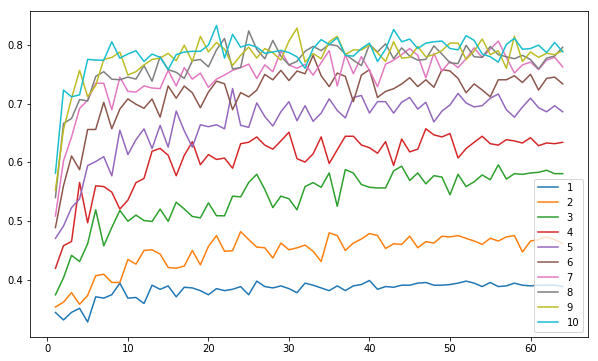

In [10]:
#https://stackoverflow.com/questions/18458734/python-plot-list-of-tuples
plt.figure(figsize=(10,6))
for depth in range(1, 11):
    plt.plot(*zip(*max_feat_acc[depth-1]), label=depth)
plt.legend()

In [25]:
# Initialize and train our tree.
start_time = time.time()
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=10,
    max_depth=9
)
decision_tree.fit(X_train, Y_train)
dt_train_time = time.time() - start_time
print("Time to train: ", dt_train_time)

Time to train:  0.008974790573120117


In [12]:
# baseline
Y_test.value_counts()/len(Y_test)

SalineControl       0.277778
MemantineControl    0.273148
MemantineTs65Dn     0.236111
SalineTs65Dn        0.212963
Name: Treated_Geno, dtype: float64

In [13]:
#(decision_tree.predict(X_test) == Y_test).sum()/len(Y_test)
decision_tree.score(X_test, Y_test)

0.7824074074074074

In [26]:
start_time = time.time()
rfc = ensemble.RandomForestClassifier(max_features=10, max_depth=9)
rfc.fit(X_train, Y_train)
rfc_train_time = time.time() - start_time
print("Time to train: ", rfc_train_time)

Time to train:  0.030916452407836914


In [21]:
rfc.score(X_test, Y_test)

0.9398148148148148

The random forest achieves pretty remarkable accuracy and a significant improvement over the decision tree. We do see that it takes roughly 3x as long to train, for what is a relatively small data set. This amount of time could quickly become prohibitive.